# Car insurance claim dataset
### Daniel Navarro Quirós
### danielnavarro2911@gmail.com

#### Context

Your client is a car insurance company. They want to price their car insurance competitively, which means having a good model for customers at risk of getting into accidents.

#### Content

Each row corresponds to a customer, the outcome column records whether the customer made a claim in the previous year or not. The client has informed you that the other columns should be self-explanatory.

### Inspiration

The client is interested to know if the customer data can be used to predict the likelihood that a claim is made in the next
year. Your task is to investigate this and make a recommendation. You should complete the following tasks:

* Build a proof-of-concept model to predict the outcome column from the customer data, including any necessary data
processing
* The client is keen to be able to interpret the model you build and would be particularly interested in understanding
which features are most important to the model's decisions.

#### Dataset extracted from [Kaggle](https://www.kaggle.com/racholsan/customer-data?select=customer-data.csv)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from ipywidgets import interact
from ipywidgets import *
import cufflinks as cf
from matplotlib import colors
cf.go_offline()
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df=pd.read_csv('customer-data.csv')

In [3]:
df.pivot_table('children','gender',aggfunc=np.sum)

,children
gender,
female,3457
male,3431


In [4]:
df.head()

,id,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,True,after 2015,False,True,10238,12000.0,sedan,0,0,0,False
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,False,before 2015,False,False,10238,16000.0,sedan,0,0,0,True
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,True,before 2015,False,False,10238,11000.0,sedan,0,0,0,False
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,True,before 2015,False,True,32765,11000.0,sedan,0,0,0,False
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,True,before 2015,False,False,32765,12000.0,sedan,2,0,1,True


In [5]:
#Converting True=1 and False=0
for i in df:
    if df[i].dtype=='bool':
        df[i]=df[i].map({True:1,False:0})

# Knowing the customers

In [6]:
columnas=df.drop('id',axis=1).columns
@interact(col=list(columnas),hue=list(columnas))
def interac(col):
    if len(df[col].unique())<=6:
        plt.figure(figsize=(10,10))
        df.groupby(col).count().reset_index()['id'].plot.pie(autopct='%1.1f%%')
        plt.title(col)
    elif 6<len(df[col].unique()) and len(df[col].unique())<20:
        plt.figure(figsize=(10,10))
        sns.countplot(data=df,x=col)
        plt.title(col)
        plt.legend(loc=1)
    else:
        plt.figure(figsize=(10,10))
        sns.displot(data=df,x=col,height=8)
        plt.title(col)
    
    

interactive(children=(Dropdown(description='col', options=('age', 'gender', 'race', 'driving_experience', 'edu…

# Some interesting facts

In [7]:
@interact(hue=['age','driving_experience','education','children','speeding_violations','DUIs','past_accidents', 'outcome'])
def acc(hue):
    plt.figure(figsize=(15,8))
    _=sns.countplot(x='past_accidents',data=df,hue=hue)
    plt.legend(loc=1)

interactive(children=(Dropdown(description='hue', options=('age', 'driving_experience', 'education', 'children…

# Missing Data

Text(0.5, 1.0, 'Missing Data')

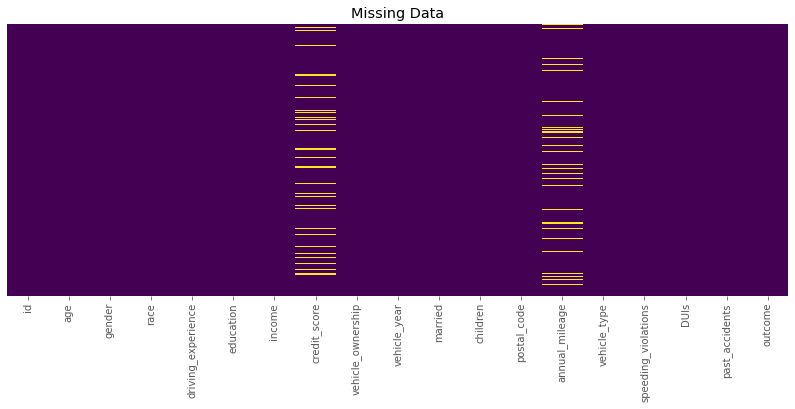

In [9]:
plt.figure(figsize=(14,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing Data')

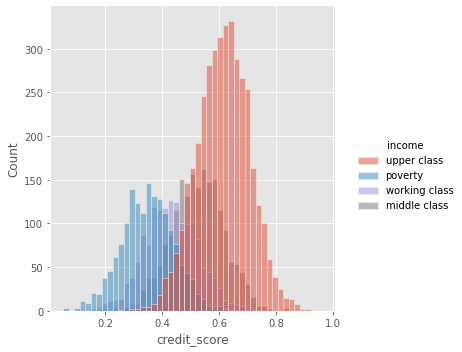

In [10]:
sns.displot(x='credit_score',data=df,hue='income')
#We can see, each income class has different credit score distribution

In [11]:
df.groupby('income')['credit_score'].describe()['mean'].reset_index()
#Here, we have the credit score mean value, grouping by the income class

,income,mean
0,middle class,0.523659
1,poverty,0.348331
2,upper class,0.613827
3,working class,0.431929


In [12]:
#filling in the missing data
def missing_score(x):
    score = x[0]
    income = x[1]
    
    if pd.isnull(score):

        if income=='middle class':
            return 0.523659

        elif income=='poverty':
            return 0.348331

        elif income=='upper class':
            return 0.613827
        else:
            return 0.431929

    else:
        return score

In [13]:
df['credit_score']=df[['credit_score','income']].apply(missing_score,axis=1)

<AxesSubplot:>

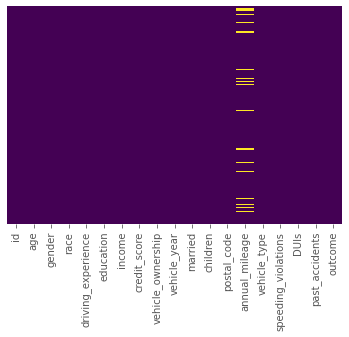

In [14]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [15]:
df1=pd.DataFrame.copy(df)

In [16]:
df1.drop(['id','race','postal_code','annual_mileage'],axis=1,inplace=True)

# Outcome feature

In [17]:
for i in df1:
    if df1[i].dtype=='O':
        var=pd.get_dummies(df1[i],drop_first=False)
        df1.drop(i,axis=1,inplace=True)
        df1=pd.concat([df1,var],axis=1)

<AxesSubplot:>

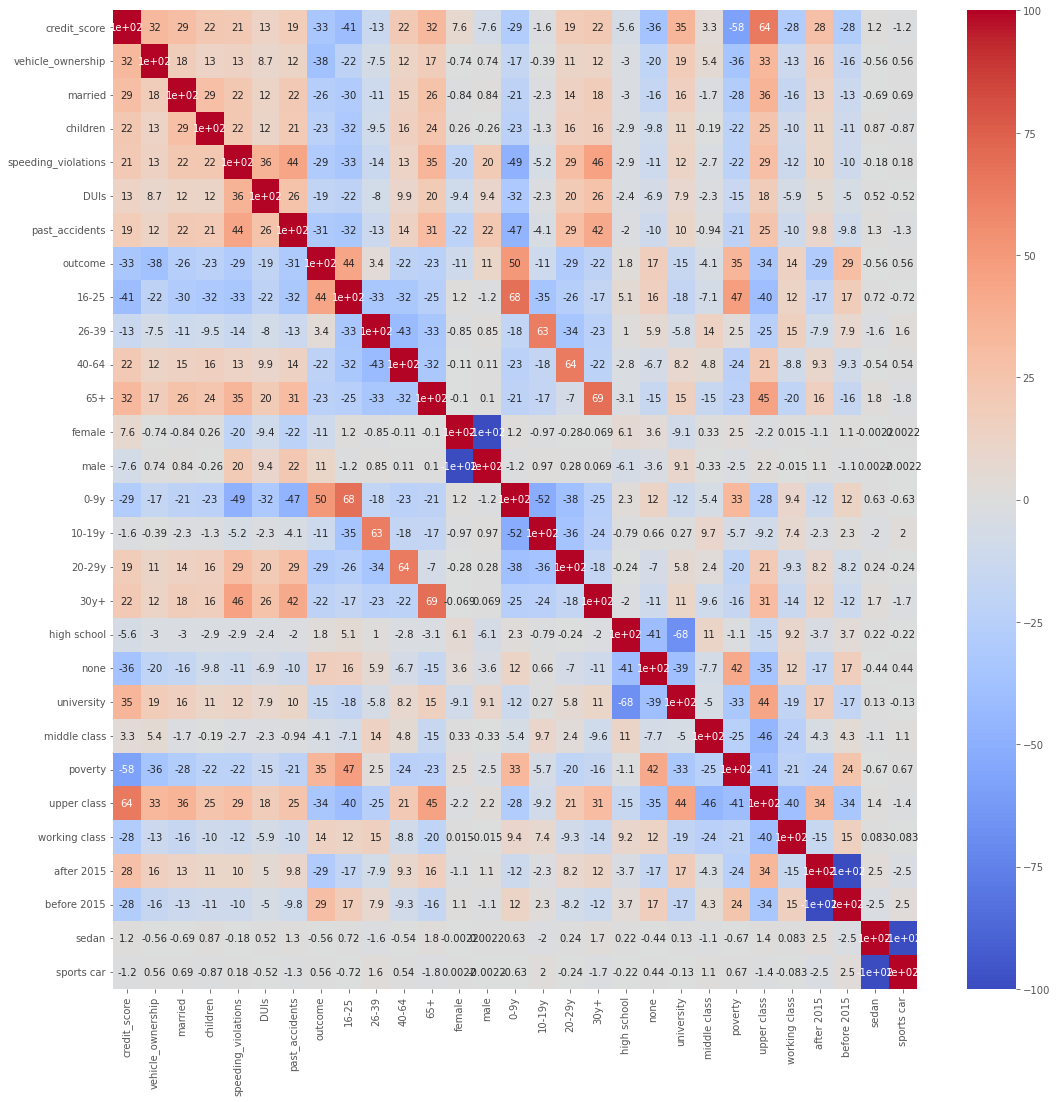

In [18]:
#correlations between all the features
plt.figure(figsize=(18,18))
sns.heatmap(data=df1._get_numeric_data().corr()*100,annot=True,cmap='coolwarm')

<AxesSubplot:title={'center':'Correlations between Outcome and all the features'}>

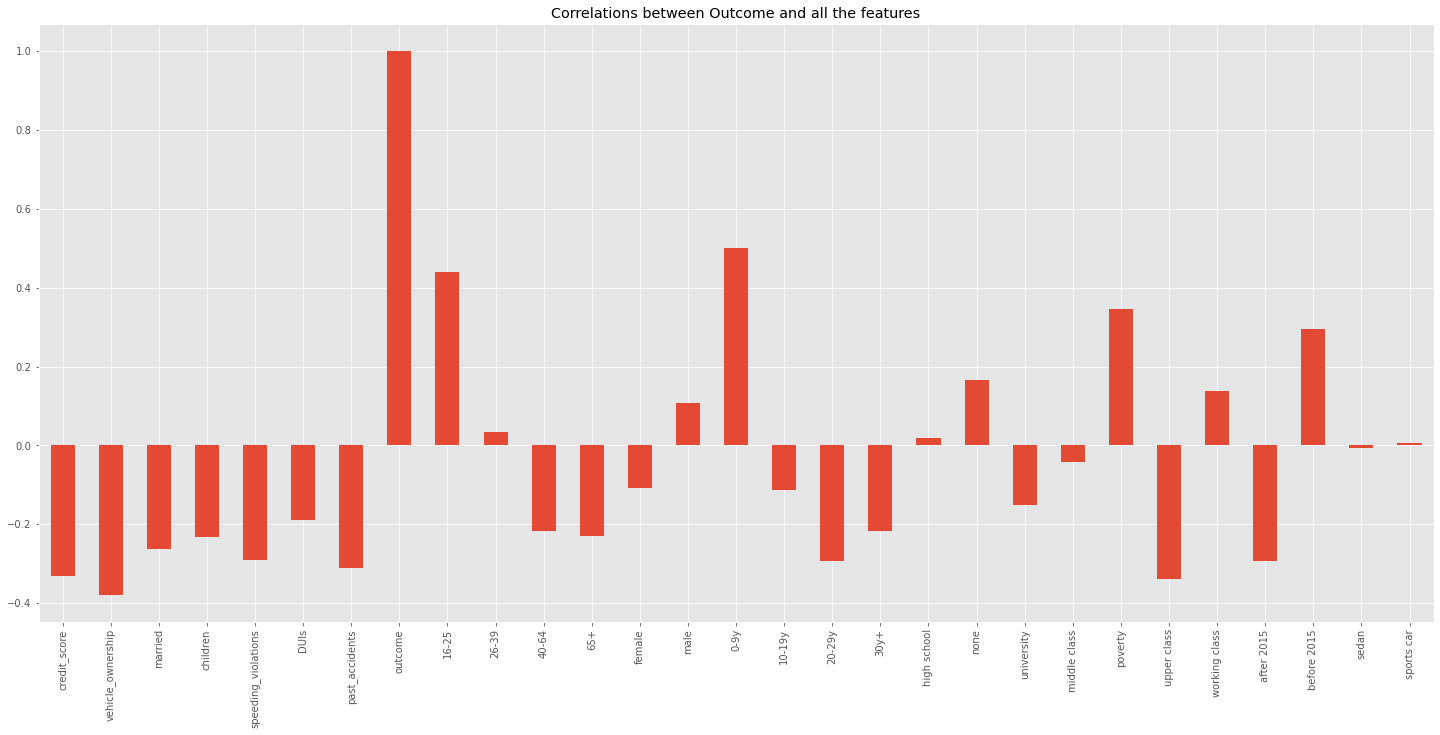

In [19]:
plt.figure(figsize=(25,11))
plt.title('Correlations between Outcome and all the features')
df1.corr()['outcome'].plot.bar()

# Recommendations
* Create strong limits with DUIS and Past accidents
* If the target is an Outcome False, focus in: Age, Driving Experience, Education, Incomes, Credit Score, Vehicle Year, Vehicle Ownership, Married
* Create a Machine Learning algorithm to predict future Outcomes


In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X=df1.drop('outcome',axis=1)
y=df1['outcome']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=101)

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [25]:
predictions = logmodel.predict(X_test)

In [26]:
from sklearn.metrics import classification_report,confusion_matrix

In [27]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      2026
           1       0.76      0.70      0.73       974

    accuracy                           0.83      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.83      0.83      0.83      3000



In [28]:
print(confusion_matrix(y_test,predictions))

[[1809  217]
 [ 289  685]]
